<a href="https://colab.research.google.com/github/Barthof/ImageMiningTeamB/blob/main/Citrus_leaves_Xception_model_with_gridsearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [ ]:
# Install imbalance learning library
!pip install imblearn

In [ ]:
# Load dataset with info and
# split first 60% of dataset into train_ds and the other two 20% into test_ds and val_ds
(train_ds, test_ds, val_ds), info = tfds.load('citrus_leaves', as_supervised=True, with_info=True, split=["train[:60%]", "train[60%:80%]", "train[80%:]"], shuffle_files=True, batch_size=-1)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [ ]:
# Split images and labels
image_train, label_train = tfds.as_numpy(train_ds)
image_test, label_test = tfds.as_numpy(test_ds)
image_val, label_val = tfds.as_numpy(val_ds)

In [ ]:
print(image_train.shape)
print(image_test.shape)
print(image_val.shape)
print(label_train.shape) 
print(label_test.shape)
print(label_val.shape)

(356, 256, 256, 3)
(119, 256, 256, 3)
(119, 256, 256, 3)
(356,)
(119,)
(119,)


Shape of image_train: (446, 256, 256, 3)

Shape of label_train: (446,)

Shape of image_test: (148, 256, 256, 3)

Shape of label_test: (148,)

In [ ]:
# Print matrix of image at index 0
print(image_train[0])

[[[217 202 203]
  [218 202 204]
  [220 204 205]
  ...
  [195 186 203]
  [192 186 201]
  [192 185 201]]

 [[218 203 203]
  [219 204 204]
  [220 204 205]
  ...
  [196 187 204]
  [192 185 200]
  [192 185 201]]

 [[218 204 204]
  [219 204 205]
  [220 204 205]
  ...
  [195 185 202]
  [194 186 203]
  [194 187 202]]

 ...

 [[ 76  51  25]
  [ 87  61  32]
  [ 91  62  38]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 62  39  16]
  [ 85  60  34]
  [100  72  45]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 56  35  18]
  [ 68  45  22]
  [102  76  48]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


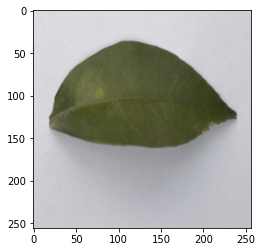

In [ ]:
# Display image
plt.imshow(image_train[1])

In [ ]:
# Extract informative features
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

print("Class names:", class_names)
print("Number of classes:", n_classes)
print("Size of training set:", len(image_train))
print("Unique labels in training set:", np.unique(label_train)) # [0: 'Black spot', 1: 'canker', 2: 'greening', 3: 'healthy']
print("Size of test set:", len(image_test))
print("Unique labels in test set:", np.unique(label_test)) # [0: 'Black spot', 1: 'canker', 2: 'greening', 3: 'healthy']

Class names: ['Black spot', 'canker', 'greening', 'healthy']
Number of classes: 4
Size of training set: 356
Unique labels in training set: [0 1 2 3]
Size of test set: 119
Unique labels in test set: [0 1 2 3]


In [ ]:
# amount per label in training set
# {0: 127, 1: 126, 2: 147, 3: 46}
print("training:", dict(sorted(Counter(label_train).items())))
# amount per label in test set
# {0: 42, 1: 37, 2: 57, 3: 12}
print("test:", dict(sorted(Counter(label_test).items())))

training: {0: 105, 1: 101, 2: 113, 3: 37}
test: {0: 32, 1: 29, 2: 47, 3: 11}


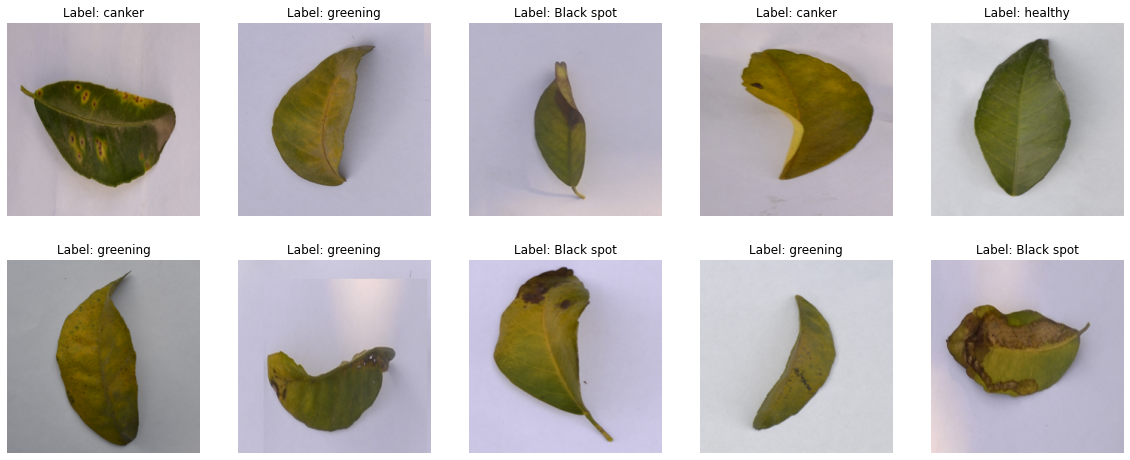

In [ ]:
import matplotlib.pyplot as plt

num_samples = 10

rand_samples = np.random.choice(np.arange(image_train.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = image_train[rand_samples[i]]
    label = label_train[rand_samples[i]]
    class_label = class_names[label]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {class_label}")
    ax.axis('off')
    ax.imshow(im)
plt.show()

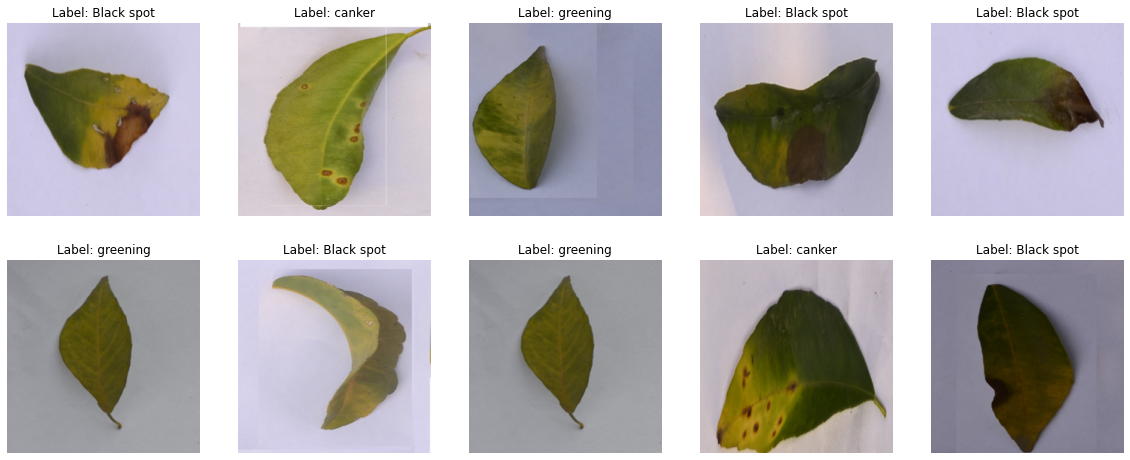

In [ ]:
num_samples = 10

rand_samples = np.random.choice(np.arange(image_test.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = image_test[rand_samples[i]]
    label = label_test[rand_samples[i]]
    class_label = class_names[label]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {class_label}")
    ax.axis('off')
    ax.imshow(im)
plt.show()

# Preprocessing

**Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator as IDG

idg_train = IDG(
    rotation_range=180,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

idg_train.fit(image_train)

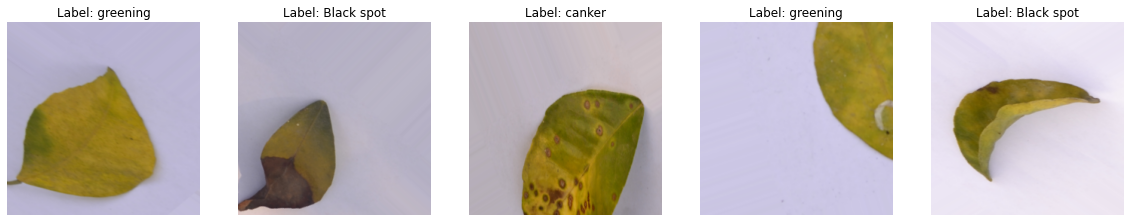

In [ ]:
fig = plt.figure(figsize=(20, 8))
for augmented_train, augmented_label in idg_train.flow(image_train, label_train, batch_size=-1):
    for i in range(0, 5):
        #plt.subplot()
        ax = fig.add_subplot(2, 5, i+1)
        label = augmented_label[i]
        class_label = class_names[label]
        ax.set_title(f"Label: {class_label}")
        ax.axis('off')
        augmented_train = augmented_train.astype('uint8')
        ax.imshow(augmented_train[i].reshape(256, 256, 3))
    break
plt.show()

In [ ]:
print(len(augmented_label))
# amount per label in augmented train set
# {0: 127, 1: 126, 2: 146, 3: 46}
print("augmented:", dict(sorted(Counter(augmented_label).items())))

355
augmented: {0: 105, 1: 101, 2: 113, 3: 36}


In [ ]:
image_train.shape, augmented_train.shape

((356, 256, 256, 3), (355, 256, 256, 3))

In [ ]:
# Append augmented data to original dataset
X_train = np.concatenate((image_train, augmented_train))
y_train = np.concatenate((label_train, augmented_label))

**Oversampling using SMOTE**

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

# Import SMOTE from imblearn library
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot

0.8.1


Class=0, n=210 (29.536%)
Class=1, n=202 (28.411%)
Class=2, n=226 (31.786%)
Class=3, n=73 (10.267%)


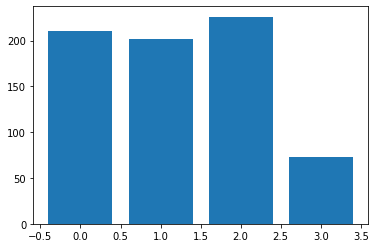

In [ ]:
# summarize distribution
counter = dict(sorted(Counter(y_train).items()))
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

**Reshape X_train data first**
*   First Flatten the image
*   Apply SMOTE on this flattened image data and its labels
*   Reshape the flattened image to RGB image

In [ ]:
from imblearn.over_sampling import SMOTE
    
sm = SMOTE(random_state=42)
    
train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)

X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1,256,256,3)

In [ ]:
# Print new shapes
print(X_train.shape) # (904, 256, 256, 3)
print(y_train.shape) # (904, 2)

(904, 256, 256, 3)
(904,)


Class=0, n=226 (25.000%)
Class=1, n=226 (25.000%)
Class=2, n=226 (25.000%)
Class=3, n=226 (25.000%)


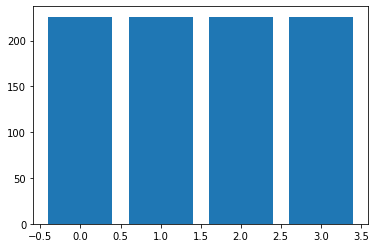

In [ ]:
# Summarize distribution after Smote
counter = dict(sorted(Counter(y_train).items()))
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

**Fix the name of other val and test data sett**

In [ ]:
# Fix the name and check the shape of validation images
X_val = image_val
print(X_val.shape)
# Fix the name and check the shape of test images
X_test = image_test
print(X_test.shape)

(119, 256, 256, 3)
(119, 256, 256, 3)


**Normalize data**

In [ ]:
X_train=X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [ ]:
#print(X_train[0])
print(X_val[0])

[[[0.81568627 0.77647059 0.81176471]
  [0.81960784 0.78039216 0.81568627]
  [0.81176471 0.77254902 0.80784314]
  ...
  [0.79607843 0.75686275 0.78823529]
  [0.78431373 0.75294118 0.78431373]
  [0.78823529 0.75294118 0.78823529]]

 [[0.81176471 0.77254902 0.80784314]
  [0.80784314 0.76862745 0.80392157]
  [0.81568627 0.77647059 0.81176471]
  ...
  [0.78823529 0.75294118 0.79215686]
  [0.78039216 0.74901961 0.79215686]
  [0.78039216 0.74901961 0.79215686]]

 [[0.81568627 0.77647059 0.81176471]
  [0.81176471 0.77254902 0.80784314]
  [0.81176471 0.77254902 0.81176471]
  ...
  [0.78823529 0.74509804 0.78823529]
  [0.78039216 0.74117647 0.78431373]
  [0.78039216 0.74117647 0.78431373]]

 ...

 [[0.75686275 0.7254902  0.78431373]
  [0.75686275 0.7254902  0.78431373]
  [0.75686275 0.7254902  0.78431373]
  ...
  [0.77647059 0.72941176 0.79215686]
  [0.78431373 0.74117647 0.79607843]
  [0.78431373 0.74117647 0.8       ]]

 [[0.76470588 0.7254902  0.78823529]
  [0.75686275 0.7254902  0.78431373]


**One Hot Encoding**

In [ ]:
# One hot encoder labels
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.reshape(-1, 1))

y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.transform(label_val.reshape(-1, 1)).toarray()
y_test = enc.transform(label_test.reshape(-1, 1)).toarray()
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(904, 4)
(119, 4)
(119, 4)


# Transfer learning with Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from tqdm import tqdm
import os
from pickle import dump

One requirement of the neural network model was to define the input shape, hence, all the images needed to in the same shape.

In [ ]:
X_train[0].shape

(256, 256, 3)

In [ ]:
input_shape = X_train[0].shape

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# make smaller batches to prevent overflowing RAM
ds_train = ds_train.batch(16)
ds_val = ds_val.batch(16)

**Define the model**

In [ ]:
def build_model(learning_rate=1e-4):
    base_model = Xception(weights="imagenet",
                          input_shape=input_shape, 
                          include_top=False)
    
    # Freeze all Xception layers and train only the classifier
    # Basically means that we don't want to train the layers again but rather directly use them for our data
    for layer in base_model.layers:
      layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # we need to recompile our model
    model.compile(optimizer=Adam(learning_rate),  # 1e-4 learning rate
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    return model

build_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 22,963,756
Trainable params: 2,102,276
Non-trainable params: 20,861,480
_________________________________________

In [ ]:
num_epochs = 5
callbacks = [
    EarlyStopping(patience=2),
]



# history = model.fit(ds_train, validation_data=ds_val, epochs=num_epochs, 
#           callbacks=callbacks)

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

classifier = KerasClassifier(build_fn=build_model)

param_grid = dict(epochs=[5, 10], learning_rate=[1e-5, 1e-4, 1e-3])
grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=None)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


Epoch 1/5


**Results**

In [ ]:
results = pd.DataFrame.from_dict(grid_result.cv_results_)

max_scores = results.groupby(['param_min_samples_split', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sn.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [ ]:
# # Accuracy plot
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
# # Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# Evaluate the generated Model (Testing)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

# Prediction for creating a Confusion matrix

In [ ]:
result=model.predict(X_test)

In [ ]:
result

In [ ]:
result[0]

In [ ]:
# Get the index of prediction 

y_true=[]
y_pred=[]
for i in range(len(result)):
    y_true.append(np.argmax(y_test[i]))
    y_pred.append(np.argmax(result[i]))

In [ ]:
print('True label', y_true)
print('Pred label:', y_pred)

In [ ]:
np.unique(y_true),np.unique(y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Confusion Matrix

In [ ]:
len(y_test)

In [ ]:
mat=confusion_matrix(y_true, y_pred)
mat

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

classes = ["0","1", "2", "3"]

'''
"0"--> label Black Spot
"1"--> label Canker
"2"--> label Greening
"3"--> label Healthy
'''


df_cfm = pd.DataFrame(mat, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True)
#cfm_plot.figure.savefig('/content/gdrive/MyDrive/result_CNN_1_5_REV/confusion_matrix.png')
plt.show()
#true y axis
# pred x axis

# Score of each class

In [ ]:
score_each_class=[]
temp=[]
for i in range(len(mat)):
    temp_sum=sum(mat[i])
    
    for j in range(len(mat[i])):
        temp.append(mat[i][j]/temp_sum)
    score_each_class.append(temp)
    temp=[]
    
score_each_class